In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
print("We 're using TF", tf.__version__)
print("We are using Keras", keras.__version__)

We 're using TF 2.9.1
We are using Keras 2.9.0


In [3]:
# Проверяем, что у нас работает GPU
tf.test.gpu_device_name()

''

In [9]:
#GPU count and name
#!nvidia-smi -L

In [10]:
#!nvidia-smi

## MNIST

In [4]:
# скачиваем данные
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

In [5]:
# что за данные
print(x_train.shape)
print(x_val.shape)
print(y_train[:10])
print(y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[5 0 4 1 9 2 1 3 1 4]
[7 2 1 0 4 1 4 9 5 9]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


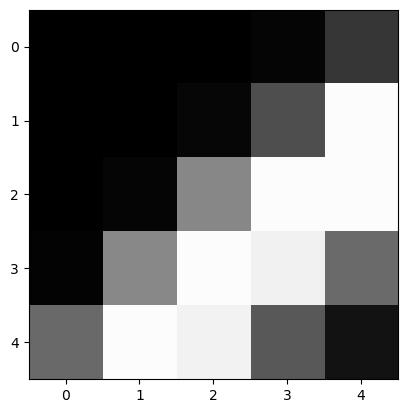

Пример картинки:


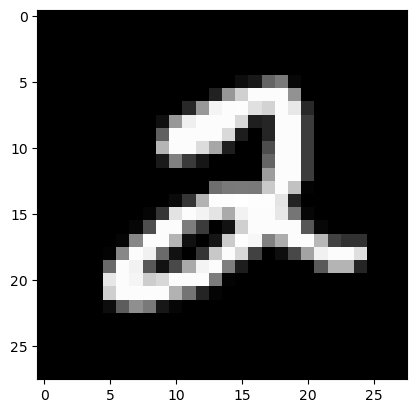

y_train [shape (60000,)] 10 примеров:
 [5 0 4 1 9 2 1 3 1 4]


In [6]:
# нарисуем картинку
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

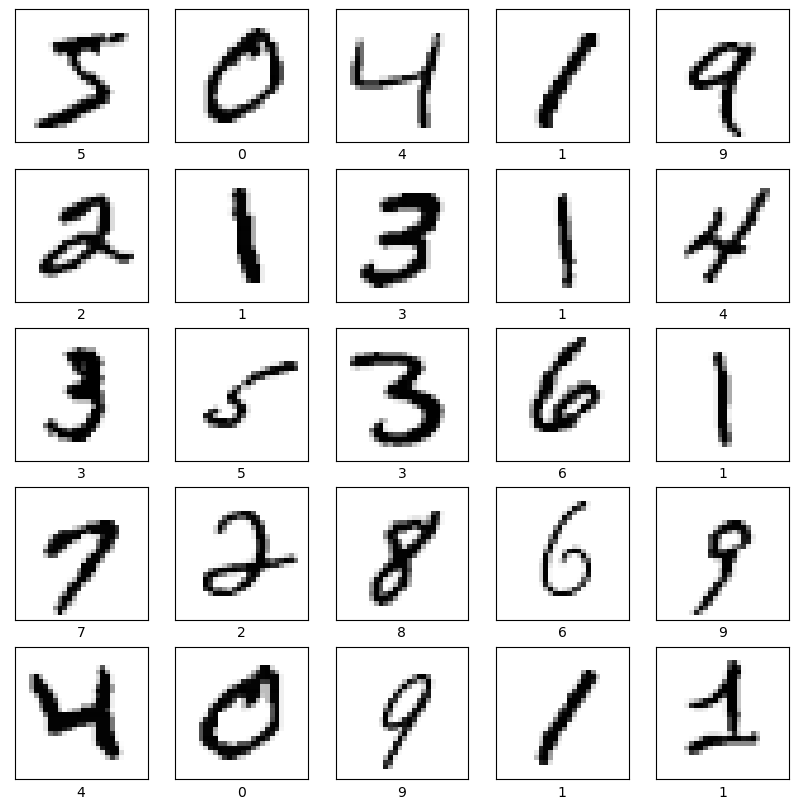

In [7]:
# Посмотрим побольше примеров
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="Greys")
    plt.xlabel(y_train[i])
plt.show()

In [8]:
# вытянем картинку в вектор размера 28*28=784 и будем использовать это как фичи!

x_train_flat = x_train.reshape(-1, 28*28).astype(float)
print(x_train.shape, x_train_flat.shape)

x_val_flat = x_val.reshape(-1, 28*28).astype(float)
print(x_val.shape, x_val_flat.shape)

(60000, 28, 28) (60000, 784)
(10000, 28, 28) (10000, 784)


In [9]:
# центрируем и нормируем, так сети будет проще учиться
x_train_float = x_train_flat.astype(np.float) / 255 - 0.5
x_val_float = x_val_flat.astype(np.float) / 255 - 0.5

# по сути, это действия аналогичны нормализации через StandartScaler
# from sklearn.preprocessing import StandartScaler
# scaler = StandartScaler()
# x_train_flat = scaler.fit_transform(x_train_flat)
# x_val_flat = scaler.transform(x_val_flat)

# Но попробуйте пропустить нормирование и посмотрите что будет ;)
# x_train_float = x_train_flat.astype(np.float)
# x_val_float = x_val_flat.astype(np.float)

C:\Users\User\AppData\Local\Temp\ipykernel_12700\2899007267.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train_float = x_train_flat.astype(np.float) / 255 - 0.5
C:\Users\User\AppData\Local\Temp\ipykernel_12700\2899007267.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_val_float = x_val_flat.astype(np.float) / 255 - 0.5


In [10]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]] [5 0 4 1 9]


## Собираем модель

![title](pic1.png)
![title](pic2.png)

In [11]:
clear_session()

In [12]:
# Архитектура сети
model = Sequential() # в Dense задаются количество нейронов на слое
model.add(Dense(256, activation='relu', input_shape=(x_train_float.shape[1],)))
model.add(Dense(128, activation='relu',))
model.add(Dense(10, activation='softmax',))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [14]:
 model.compile(
     loss='categorical_crossentropy', # минимизируем кросс-энтропию
     optimizer='adam', # так будет быстрее, позже узнаем что это :)
     metrics=['accuracy'] # выводим процент правильных ответов
 )

In [15]:
history = model.fit(
                    x_train_float,
                    y_train_oh,
                    batch_size=64, # 64 объекта для подсчета градиента на каждом шаге
                    epochs=10, # 10 проходов по датасету
                    validation_data=(x_val_float, y_val_oh)
                    )

Epoch 1/10
938/938 [==============================] - 4s 3ms/step - loss: 0.3136 - accuracy: 0.9050 - val_loss: 0.1638 - val_accuracy: 0.9476
Epoch 2/10
938/938 [==============================] - 2s 3ms/step - loss: 0.1447 - accuracy: 0.9566 - val_loss: 0.1364 - val_accuracy: 0.9555
Epoch 3/10
938/938 [==============================] - 2s 3ms/step - loss: 0.1072 - accuracy: 0.9672 - val_loss: 0.1090 - val_accuracy: 0.9653
Epoch 4/10
938/938 [==============================] - 2s 3ms/step - loss: 0.0888 - accuracy: 0.9726 - val_loss: 0.1216 - val_accuracy: 0.9624
Epoch 5/10
938/938 [==============================] - 2s 3ms/step - loss: 0.0721 - accuracy: 0.9773 - val_loss: 0.0944 - val_accuracy: 0.9711
Epoch 6/10
938/938 [==============================] - 2s 3ms/step - loss: 0.0641 - accuracy: 0.9795 - val_loss: 0.1005 - val_accuracy: 0.9702
Epoch 7/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0560 - accuracy: 0.9823 - val_loss: 0.1117 - val_accuracy: 0.9656
Epoch 

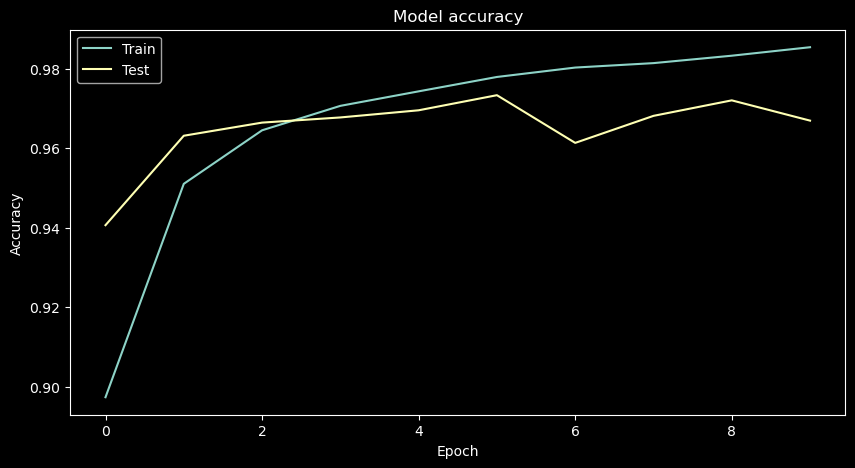

In [29]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

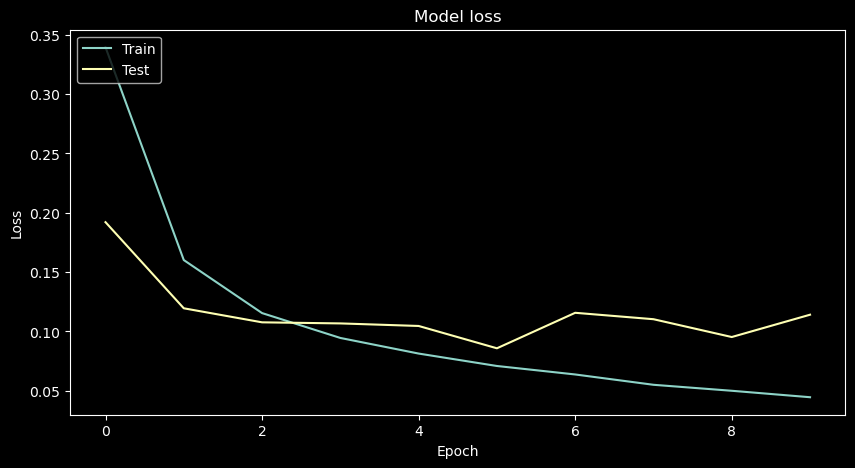

In [32]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
model.predict(x_val_float)

313/313 [==============================] - 0s 1ms/step


array([[4.9190070e-09, 8.8947343e-11, 3.1770782e-08, ..., 9.9999827e-01,
        1.1145511e-08, 1.5162971e-06],
       [4.0175693e-10, 3.7056654e-06, 9.9999613e-01, ..., 9.4918049e-12,
        9.7877573e-10, 5.4938848e-16],
       [7.2227522e-07, 9.9956989e-01, 7.7233508e-06, ..., 2.4468813e-04,
        1.1633659e-04, 1.8782775e-05],
       ...,
       [1.2255107e-15, 7.9509637e-12, 7.3471161e-16, ..., 2.4606054e-08,
        2.8234207e-10, 2.6039906e-10],
       [2.5807774e-06, 1.0627142e-10, 3.1556820e-11, ..., 3.0745586e-08,
        1.8989957e-04, 5.0389363e-12],
       [3.1131876e-14, 7.8351964e-19, 1.5673250e-13, ..., 3.9549517e-17,
        4.9668958e-14, 2.8923455e-17]], dtype=float32)

In [38]:
# (ошибка, нет такого метода)
# model.predict_classes(x_val_float)

In [17]:
# аналогично
np.argmax(model.predict(x_val_float), axis = 1)

313/313 [==============================] - 0s 1ms/step


array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [18]:
predicts = np.argmax(model.predict(x_val_float), axis = 1)
print('Test Accuracy: ', accuracy_score(y_val, predicts))

313/313 [==============================] - 0s 1ms/step
Test Accuracy:  0.9751
